In [1]:
import os,sys,inspect

import pnsolver

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import util
import stencil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import ipywidgets as widgets
from ipywidgets.widgets.interaction import interact

 # Use interactive matplotlib backend, which runs in the browser
%matplotlib notebook

In [2]:
def load_pn_solution(filename):
    data = util.load_pn_system(filename)
    staggered = False
    pni = stencil.PNInfo2D( data["order"], staggered )
    domain = pnsolver.Domain( np.array([7.0, 7.0]), data["resolution"], np.array([0.0, 0.0]) )
    data["domain"] = domain
    data["pni"] = pni
    
    x_complex = pni.to_complex(data["x"])

    # contruct radiance field from coefficients
    L = pnsolver.SHEXP( data["order"] )
    for index in range(data["numCoeffs"]):
        (l,m) = pni.lm_index(index)
        sh_index = util.sh_index(l,m)
        offset = pni.getOffset(index)*0.5

        u0 = util.extract_coefficient_field( x_complex, data["resolution"], data["numCoeffs"], index )
        L.setCoefficientField( l, m, pnsolver.VoxelGrid( u0, domain, offset ) )
        #print(u0.dtype)
    data["L"] = L
    return data

def render(L, pWS):
    plot_y = np.arange(0, 2, 0.01)
    plot_x = 2 * np.pi * plot_y

    for i in range(plot_x.shape[0]):
        phi = plot_x[i]
        omega = util.sphericalDirection(np.pi*0.5, phi)
        # for some reason (I still have to investigate) the direction seems to be inverted
        # for our solution
        #omega = -omega
        plot_y[i] = np.real(L.eval(pWS, np.array([omega[0], omega[1]])))
    return (plot_x, plot_y)

In [3]:
datasets = []

datasets.append(("from id", "---"))
#datasets.append(("checkerboard fopn p1", "C:/projects/epfl/epfl17/python/pnsolver/results/studies/checkerboard_fopn_p1.mat"))
#datasets.append(("checkerboard fopn p2", "C:/projects/epfl/epfl17/python/pnsolver/results/studies/checkerboard_fopn_p2.mat"))
#datasets.append(("checkerboard fopn p3", "C:/projects/epfl/epfl17/python/pnsolver/results/studies/checkerboard_fopn_p3.mat"))
#datasets.append(("checkerboard fopn p4", "C:/projects/epfl/epfl17/python/pnsolver/results/studies/checkerboard_fopn_p4.mat"))
#datasets.append(("checkerboard fopn p5", "C:/projects/epfl/epfl17/python/pnsolver/results/studies/checkerboard_fopn_p5.mat"))
#datasets.append(("checkerboard sopn p1", "C:/projects/epfl/epfl17/python/pnsolver/results/studies/checkerboard_sopn_p1.mat"))
#filename = "C:/projects/epfl/epfl17/python/pnsolver/results/studies/vacuum_sopn_p1.mat"
#filename = "C:/projects/epfl/epfl17/python/pnsolver/results/studies/checkerboard_sopn_p1_vacuum.mat"
#filename = "C:/projects/epfl/epfl17/python/notebooks/sopn/solution_checkerboard_blur10.0_term1.mat"

In [75]:
def make_plot():
    global msg
    figsize = plt.figaspect(1/2)
    #fig, ax = plt.subplots(1, 2, figsize=figsize)
    
    fig = plt.figure(figsize=figsize);
    ax = [None, None, None]
    ax[0] = fig.add_subplot(121)
    #ax[1] = fig.add_subplot(122)
    ax[1] = fig.add_subplot(122, projection='polar')
    #ax[2] = fig.add_subplot(133)

    
    # Plot 1 =============================================
    # Draw an empty image
    img_view = ax[0].imshow(np.zeros((1,1)), cmap='jet', origin='lower')
    
    # Add a nice color bar
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(img_view, cax=cax)

    # Plot 2 =============================================
    # Add an empty plot of the SH coefficients ------
    plot_view = ax[1].plot(np.zeros((1)))[0]
    ax[1].set(adjustable="datalim")
    ax[1].set_rmax(1.0)
    #plot_view = ax[1].imshow(np.zeros((1,1)), cmap='jet', origin='lower')
    

    result = { 'img_view' : img_view,
               'img_ax' : ax[0],
               'plot_view' : plot_view,
               'plot_ax' : ax[1],
               #'img_view2':img_view2,
               #'img_ax2':ax[2],
               'dataset_filename':None
             }
    
    def on_click(event):
        global msg
        if event.inaxes is not ax[0] or 'on_click_handler' not in result:
            return
        result['on_click_handler'](np.array([event.ydata, event.xdata]))

    fig.canvas.mpl_connect('button_press_event', on_click)
    fig.tight_layout()

    return result

def plot_interact(plot):
    def redraw(dataset_id, coeff_index, display_absolute_value):
        img_view = plot['img_view']
        plot_view = plot['plot_view']
        plot_ax = plot['plot_ax']
        
        dataset_filename = "C:/projects/epfl/epfl17/python/pnsolver/results/studies/checkerboard{}.mat".format(dataset_id)
        if dataset_filename != plot['dataset_filename']:
            plot['dataset_filename'] = dataset_filename
            plot["data"] = load_pn_solution(dataset_filename)

        data = plot["data"]
        domain = data["domain"]
        pni = data["pni"]
        L = data["L"]
                    
        #filename = "C:/projects/epfl/epfl17/python/pnsolver/results/studies/checkerboard_groundtruth.mat"
        #groundtruth_image = util.load_pn_system(filename)["x"]
        #groundtruth_image = np.clip(image, 1.0e-8, np.max(image))
        #plot_view.set_norm(LogNorm(vmin=np.min(groundtruth_image), vmax=np.max(groundtruth_image)))
        #plot_view.set_extent((domain.getBoundMin()[0], domain.getBoundMax()[0], domain.getBoundMin()[1], domain.getBoundMax()[1]))
        #plot_view.set_data(groundtruth_image.T)

            

        
        # update plot 1 =======================================
        u = util.extract_coefficient_field( data["x"], data["resolution"], data["numCoeffs"], coeff_index )
        
        if display_absolute_value == True:
            u = np.abs( u)
        else:
            u = np.clip( u, 1.0e-8, np.max(u) )
        #u = np.abs(u)
        #print( "min={} max={}".format(np.min(u), np.max(u)) )
        
        # Update the plot
        img_view.set_data(u.T)
        #img_view.set_clim(vmin=0, vmax=np.percentile(data_slice, 99))
        #img_view.set_clim(vmin=np.min(u), vmax=np.max(u))
        img_view.set_norm(LogNorm(vmin=np.min(u), vmax=np.max(u)))
        img_view.set_extent((domain.getBoundMin()[0], domain.getBoundMax()[0], domain.getBoundMin()[1], domain.getBoundMax()[1]))
        
        # update plot 2 =======================================
        def on_click_handler(pos):
            pWS = np.array([pos[1], pos[0]])
            (plot_x, plot_y) = render(L, pWS)
            plot_y = plot_y/np.max(plot_y)
            plot_view.set_data(plot_x, plot_y)
        
        plot['on_click_handler'] = on_click_handler

    #slice_index_widget = widgets.IntSlider(
    #    min=0,
    #    max=127,
    #    value=64,
    #    description='Slice'
    #)
    
    dataset_id_widget = widgets.Text(
        value='_fopn_p1_sg',
        placeholder='Type something',
        description='String:',
        disabled=False
    )
    
    #rightside_index_widget = widgets.Dropdown(
    #    options=[("L", 0), ("groundtruth", 1)],
    #    value=0,
    #    description='right side'
    #)
   
    coeff_index_widget = widgets.IntSlider(
        min=0,
        max=2,
        value=0,
        description='coefficient'
    )
    
    display_absolute_value_widget = widgets.ToggleButton(
    value=False,
    description='absolute',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check'
    )
    
    
    #interact(redraw, dataset_index=dataset_index_widget, slice_index=slice_index_widget, coeff_index=coeff_index_widget)
    interact(redraw, dataset_id=dataset_id_widget, coeff_index=coeff_index_widget, display_absolute_value = display_absolute_value_widget)

<IPython.core.display.Javascript object>


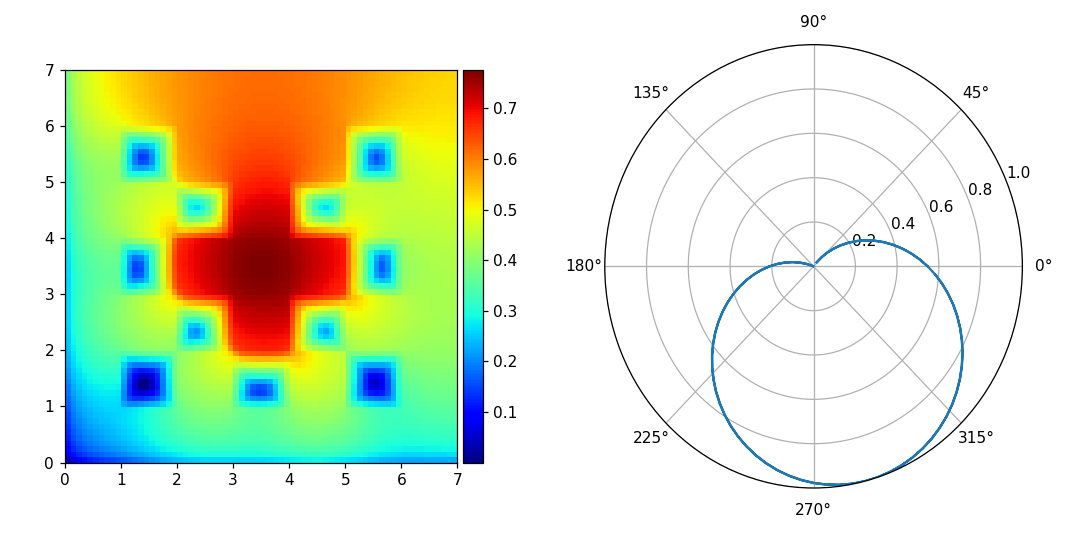

In [76]:
plot = make_plot()

In [77]:
plot_interact(plot)

loading PN solution from C:/projects/epfl/epfl17/python/pnsolver/results/studies/checkerboard_fopn_p1_sg.mat
	order=1  numCoeffs=3  resolution=70 70


In [ ]:
filename = "C:/projects/epfl/epfl17/python/pnsolver/results/studies/checkerboard_sopn_p1_sg.mat"
#filename = "C:/projects/epfl/epfl17/python/pnsolver/results/studies/vacuum_sopn_p1.mat"
#filename = "C:/projects/epfl/epfl17/python/pnsolver/results/studies/checkerboard_sopn_p1_vacuum.mat"
#filename = "C:/projects/epfl/epfl17/python/notebooks/sopn/solution_checkerboard_blur10.0_term1.mat"

In [ ]:
data = load_pn_solution(filename)
domain = data["domain"]
L = data["L"]

In [ ]:
#rows = np.arange(0, 7.0, 0.1)

#print(plot_x.shape)

(plot_x,plot_y) = render(data["L"], np.array([3.5, 3.5]))

res_x = 70

image = np.zeros((res_x, plot_x.shape[0]))

for i in range(res_x):
    pVS = np.array([i+0.5, 35])
    #pWS = domain.voxelToWorld( pVS )
    pWS = np.array([3.5, 1.5])
    (plot_x,plot_y) = render(data["L"], pWS)
    image[i, :] = plot_y
    
image = np.clip(image, 1.0e-8, np.max(image))
#image = np.abs(image)
    
fig = plt.figure(figsize=(8,8));
ax = fig.add_subplot(111)
img_view = ax.imshow(image, cmap='jet', norm=LogNorm(vmin=np.min(image), vmax=np.max(image)), origin='lower')
plt.show()

loading PN solution from C:/projects/epfl/epfl17/python/pnsolver/results/studies/checkerboard_groundtruth.mat
	order=0  numCoeffs=1  resolution=70 70
float64
1e-08
0.04083275


<IPython.core.display.Javascript object>


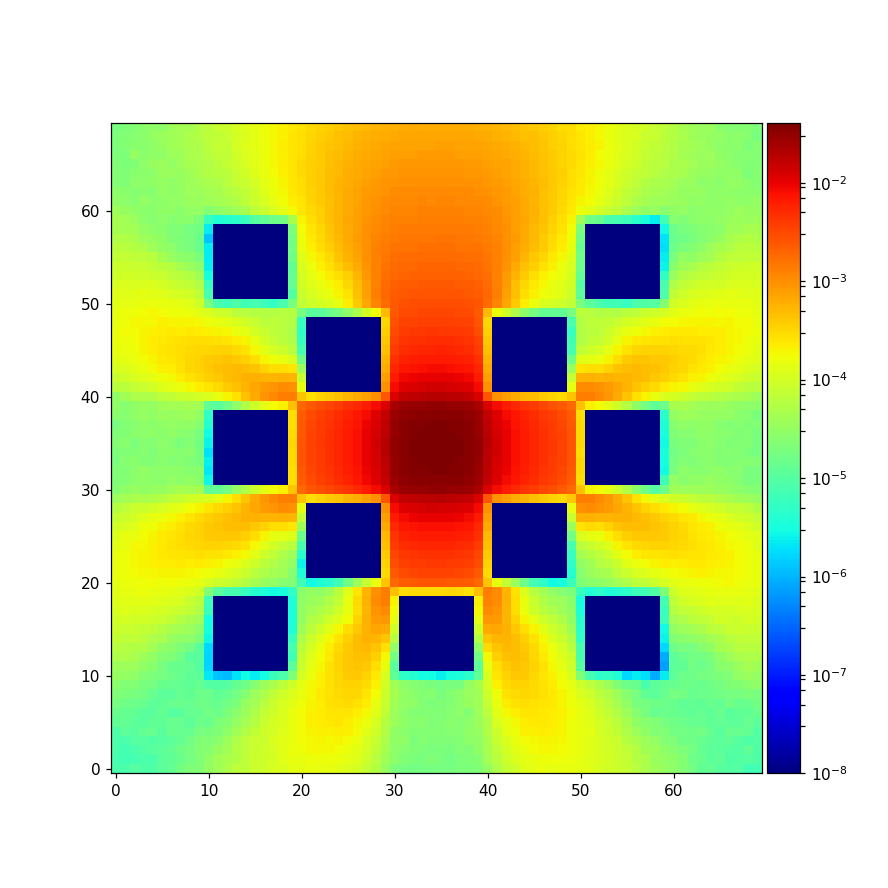

In [42]:
filename = "C:/projects/epfl/epfl17/python/pnsolver/results/studies/checkerboard_groundtruth.mat"
data = util.load_pn_system(filename)
image = data["x"]
image = np.clip(image, 1.0e-8, np.max(image))
print(data["x"].dtype)
print(np.min(image))
print(np.max(image))


fig = plt.figure(figsize=(8,8));
ax = fig.add_subplot(111)
img_view = ax.imshow(image.T, cmap='jet', norm=LogNorm(vmin=np.min(image), vmax=np.max(image)), origin='lower')
#img_view = ax.imshow(image, cmap='jet', vmin=np.min(image), vmax=np.max(image), origin='lower')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img_view, cax=cax)

plt.show()